<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span><ul class="toc-item"><li><span><a href="#Log" data-toc-modified-id="Log-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Log</a></span></li><li><span><a href="#To-do" data-toc-modified-id="To-do-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>To do</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Architecture" data-toc-modified-id="Architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Architecture</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loss</a></span><ul class="toc-item"><li><span><a href="#Anchors-&amp;-anchor-boxes" data-toc-modified-id="Anchors-&amp;-anchor-boxes-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Anchors &amp; anchor boxes</a></span></li><li><span><a href="#Loss-functions-for-separate-tasks" data-toc-modified-id="Loss-functions-for-separate-tasks-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loss functions for separate tasks</a></span></li><li><span><a href="#Intersection-Over-Union-(IOU)" data-toc-modified-id="Intersection-Over-Union-(IOU)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Intersection Over Union (IOU)</a></span></li><li><span><a href="#Putting-it-together" data-toc-modified-id="Putting-it-together-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Putting it together</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#More-Boxes" data-toc-modified-id="More-Boxes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>More Boxes</a></span><ul class="toc-item"><li><span><a href="#Focal-loss-&amp;-training" data-toc-modified-id="Focal-loss-&amp;-training-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Focal loss &amp; training</a></span></li></ul></li></ul></div>

# Summary

Diving deep into DL4C 2018 lesson 9 to implement SSD object detection ([link to the video here](https://www.youtube.com/watch?v=0frKXR-2PBY)).

## Log

- 2020-10-27 (Tues): Started implementing Jeremy's solution w/ anchor boxes in 2018.9. Made progress. Left off video at 57:49.
- 2020-11-05 (Thurs): Discovered bug in reading from pickled dataframe that was causing multilabel tensors to be created as float dtype instead of int dtype.
- 2020-11-06 (Fri): It's working! I got it working last night, but today I looked at the results, and they totally make sense! Still a few things to do, but this is a great result.

## To do

- Prune overlapping output bboxes
- Output more anchor bboxes
- Test with data outside of validation

# Data

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
valid_pct  = .10
subset_pct = .3

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'


### Get Items ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*subset_pct)]
dls = db.dataloaders(subset)


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 32999
Size of valid data: 3666
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 33, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 33])


# Architecture

In [ ]:
# StdConv (used in SSD_Head) wraps together the standard conv2d → batchnorm → dropout.
class StdConv(Module):
    # 42:00
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))


# OutConv (used in SSD_Head) creates two output layers (one for bboxes, one for lbls).
class OutConv(Module):
    # output is two conv layers (instead of one linear layer)
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [self._flatten_conv(self.oconv1(x), self.k),
                self._flatten_conv(self.oconv2(x), self.k)]
    
    def _flatten_conv(self,x,k):
        return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)


# SSD_Head 
class SSD_Head(Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

    
class Custom_Module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

# Loss

## Anchors & anchor boxes

In [ ]:
### Anchors ###
def create_anchors(k=1, subdivs=4, device='cuda'):
    box_size = 1/subdivs
    anc_offset = box_size*.5
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_hws = np.array([[box_size,box_size] for i in range(subdivs**2)])
    anchors = torch.cat((tensor(anc_ctrs), tensor(anc_hws)), axis=1)
    box_size = tensor(np.array([box_size]), requires_grad=False).unsqueeze(1)
    return anchors.to(device), box_size.to(device)
anchors, box_size = create_anchors()

def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

## Loss functions for separate tasks

In [ ]:
# lbl_loss will use binary cross entropy
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()]

class BCE_Loss(nn.Module):
    # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous()).type_as(a) # can I remove type_as?
        w = self.get_weight(a,t)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls
    
    def get_weight(self,a,t): return None
    
# bb_loss will use mean absolute error
def mae(t1, t2):
    return ((t1 - t2).abs()).mean()

## Intersection Over Union (IOU)

In [ ]:
### IOU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)

def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union

## Putting it together

In [ ]:
### SSD Loss ##
def remove_padding(bb, lbl):
    # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]

def adjust_anchor_boxes(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return create_anchor_boxes(ctrs, hws)

def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs

def ssd_item_loss(act_bb, act_lbl, bb, lbl):
    # 1:11:30
    bb, lbl = remove_padding(bb, lbl)
    pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
    ious = get_iou(bb.data, anchor_boxes.data)
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx]
    # assign fxns to bb_loss and lbl_loss
    bb_loss_res = bb_loss(pred_bb[assigned_idx], targ_bb[assigned_idx])
    lbl_loss_res = lbl_loss(act_lbl, targ_lbl)
    return bb_loss_res, lbl_loss_res

def ssd_loss(acts, bbs, lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for act_bb,act_lbl,bb,lbl in zip(*acts, bbs, lbls):
        bb_loss,lbl_loss = ssd_item_loss(act_bb,act_lbl,bb,lbl)
        sum_bb_loss += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

# Training

In [ ]:
k=1
head_reg4 = SSD_Head(k, -3.)
body = create_body(resnet34, pretrained=True)
mod = Custom_Module(body, head_reg4)
bb_loss = mae
lbl_loss = BCE_Loss(len(dls.vocab)) # fxn assigned

learner = Learner(dls, mod, loss_func = ssd_loss)
learner.freeze()

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0012022644514217973)

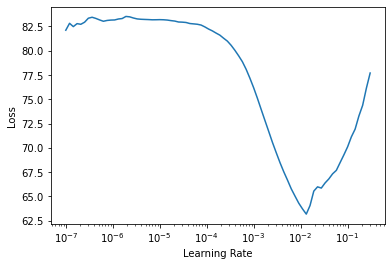

In [ ]:
learner.lr_find()

JH's loss values:
- epoch 0: 44, 34
- epoch 4: 26, 26

Mine:
- epoch 0: 29, 30
- epoch 4: 21, 24

In [ ]:
learner.fit_one_cycle(10,lr=3e-4)

epoch,train_loss,valid_loss,time
0,28.220053,28.692825,02:15
1,27.664362,28.644037,02:14
2,26.500937,26.811625,02:15
3,24.905432,26.211550,02:15
4,23.471186,24.835779,02:15
5,21.780245,24.371601,02:15
6,19.705700,24.497667,02:15
7,17.698301,24.771591,02:16
8,16.129772,25.452168,02:16
9,15.073561,25.786345,02:16


In [ ]:
learner.save('20201106_coco_ssd_5e_24l')

Path('models/20201106_coco_ssd_5e_24l.pth')

In [ ]:
learner.export('20201106_coco_ssd_test_export')

# Results

In [ ]:
def show_bb(im, bb, lbl, sz=224,figsize=[5,5],color='white',ctx=None,title=None):
    # process tensors to take advantage of fastai show methods
    bbox = TensorBBox((bb+1)*sz//2)
    labeledbbox = LabeledBBox(bbox,lbl)
    
    if ctx: show_image(im, figsize=figsize, title=title, ctx=ctx)
    else:   ctx = show_image(im, figsize=figsize, title=title)
    
    labeledbbox.show(ctx=ctx)       # first, draw white lbl bbs...
    bbox.show(ctx=ctx, color=color) # ... then overlay color bbs.
    return ctx

JH uses b_clasi and b_bboxi for his model outputs (acts), and bbox and clas for his batch outputs.

In [ ]:
# grab batch and acts (52m)
batch = dls.one_batch()
b_ims, b_bbs, b_lbls = batch

In [ ]:
# grab acts
learner.model.eval()
learner.model.cuda()
acts = learner.model(b_ims)
act_bbs, act_lbls = acts

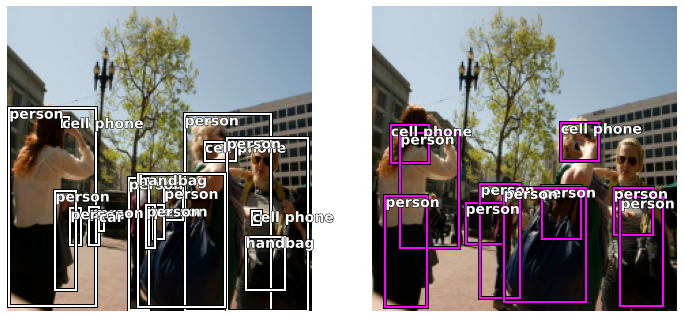

In [ ]:
idx=12
# grab single item & acts
bb  = b_bbs[idx]
lbl = b_lbls[idx]
act_bb  = act_bbs[idx]
act_lbl = act_lbls[idx]
decoded_batch = dls.decode(batch)
im = decoded_batch[0][idx]

# convert acts to pred
pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
pred_lbl = act_lbl.max(1)[1]
is_bg = pred_lbl==0
pred_bb = pred_bb[~is_bg]
pred_lbl = pred_lbl[~is_bg]

# show pred
ctx = get_grid(2, figsize=[12,12])
show_bb(im, bb, dls.vocab[lbl], sz=im_size, ctx=ctx[0]);
show_bb(im, pred_bb, dls.vocab[pred_lbl], sz=im_size, color='magenta', ctx=ctx[1]);

# More Boxes

- To implement more boxes, we need more anchors, but also more output activations.
- More outputs:
    - Add additional output layers. Currently we have a final 4x4 layer which we use for the grid of 16 anchor boxes. We can add another stride 2 layer to get that down to 2x2, which can give us 4 large anchor boxes. Add another layer with another stride 2 to get a 1x1.
- More anchors:
    - Doing the above will give us another 4 + 1 anchor boxes. 

In [ ]:
### New anchor calculations
def create_anchors(subdivs, zooms, ratios, device='cuda'):
    # create list of permutations per default anchor box
    perms = [(z*r1,z*r2) for z in zooms for (r1,r2) in ratios]
    k = len(perms)
    offsets = [1/(sd*2) for sd in subdivs]
    xs = np.concatenate([np.repeat(np.linspace(o, 1-o, sd), sd)
                         for o,sd in zip(offsets, subdivs)])
    ys = np.concatenate([np.tile  (np.linspace(o, 1-o, sd), sd)
                         for o,sd in zip(offsets, subdivs)])
    ctrs = np.repeat(np.stack([xs,ys], axis=1), k, axis=0)
    hws = np.concatenate([np.array([[o/sd,p/sd] for i in range(sd*sd) for o,p in perms]) 
                          for sd in subdivs])
    box_sizes = tensor(np.concatenate([np.array([1/sd for i in range(sd*sd) for o,p in perms])
                                      for sd in subdivs]), requires_grad=False).unsqueeze(1)
    anchors = tensor(np.concatenate([ctrs, hws], axis=1), requires_grad=False).float()
    return anchors.to(device), box_sizes.to(device)

def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1

In [ ]:
# New model head
drop = 0.4
class SSD_MultiHead(Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
#         self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

In [ ]:
# init anchors
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

# init learner
body = create_body(resnet34, pretrained=True)
head = SSD_MultiHead(k, -4.)
mod  = Custom_Module(body, head)
learner = Learner(dls, mod, loss_func=ssd_loss)

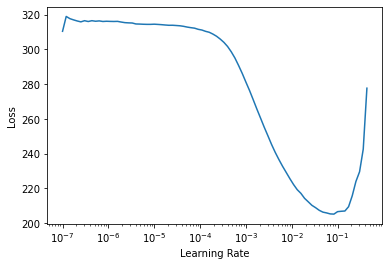

In [ ]:
lr_min,lr_steep = learner.lr_find(show_plot=True)

In [ ]:
doc(Learner.fit_one_cycle)

In [ ]:
learner.fit_one_cycle(5, lr_max=lr_min)

epoch,train_loss,valid_loss,time
0,77.794937,75.058548,02:17
1,69.126244,68.062180,02:18
2,67.349396,64.955940,02:18
3,61.578018,61.090588,02:18
4,61.104179,59.980377,02:18


In [ ]:
# grab batch and acts (52m)
batch = dls.one_batch()
b_ims, b_bbs, b_lbls = batch

In [ ]:
# grab acts
learner.model.eval()
learner.model.cuda()
acts = learner.model(b_ims)
act_bbs, act_lbls = acts

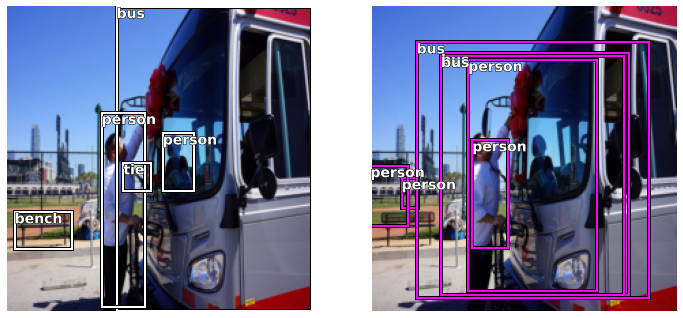

In [ ]:
idx=2
# grab single item & acts
bb  = b_bbs[idx]
lbl = b_lbls[idx]
act_bb  = act_bbs[idx]
act_lbl = act_lbls[idx]
decoded_batch = dls.decode(batch)
im = decoded_batch[0][idx]

# convert acts to pred
pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
pred_lbl = act_lbl.max(1)[1]
# filter out bg and low-conf lbl preds
is_bg = (pred_lbl==0)
is_confident = act_lbl.max(1)[0].sigmoid() > .1
fltr = [a and b for a,b in zip(~is_bg, is_confident)]
pred_bb = pred_bb[fltr]
pred_lbl = pred_lbl[fltr]

# show pred
ctx = get_grid(2, figsize=[12,12])
show_bb(im, bb, dls.vocab[lbl], sz=im_size, ctx=ctx[0]);
show_bb(im, pred_bb, dls.vocab[pred_lbl], sz=im_size, color='magenta', ctx=ctx[1]);

## Focal loss & training

In [ ]:
class FocalLoss(BCE_Loss):
    def get_weight(self, a, t):
        alpha, gamma = 0.25, 2.0 # vals from paper
        p = a.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

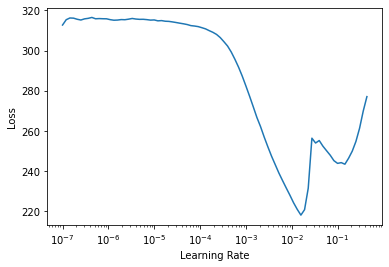

In [ ]:
# init anchors
subdivs = [4, 2, 1]
zooms   = [0.75, 1.0, 1.3]
ratios  = [(1.,1.), (1.,.5), (.5,1)]
k = len(zooms) * len(ratios)
anchors, box_size = create_anchors(subdivs, zooms, ratios)
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])

# init loss
bb_loss  = mae
lbl_loss = FocalLoss(len(dls.vocab))

# init learner
body = create_body(resnet34, pretrained=True)
head = SSD_MultiHead(k, -4.)
mod  = Custom_Module(body, head)
learner = Learner(dls, mod, loss_func=ssd_loss)
lr_min,lr_max = learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, lr_max=lr_min)

epoch,train_loss,valid_loss,time
0,72.459267,71.551949,02:23
1,65.386520,63.496334,02:24
2,59.071999,57.910786,02:23
3,53.743927,54.125919,02:24
4,51.162285,53.277096,02:24


In [ ]:
# grab batch and acts (52m)
batch = dls.one_batch()
b_ims, b_bbs, b_lbls = batch

In [ ]:
# grab acts
learner.model.eval()
learner.model.cuda()
acts = learner.model(b_ims)
act_bbs, act_lbls = acts

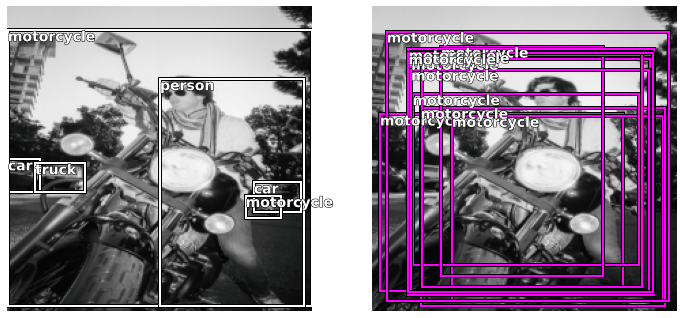

In [ ]:
idx=1
# grab single item & acts
bb  = b_bbs[idx]
lbl = b_lbls[idx]
act_bb  = act_bbs[idx]
act_lbl = act_lbls[idx]
decoded_batch = dls.decode(batch)
im = decoded_batch[0][idx]

# convert acts to pred
pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
pred_lbl = act_lbl.max(1)[1]
# filter out bg and low-conf lbl preds
is_bg = (pred_lbl==0)
is_confident = act_lbl.max(1)[0].sigmoid() > .1
fltr = [a and b for a,b in zip(~is_bg, is_confident)]
pred_bb = pred_bb[fltr]
pred_lbl = pred_lbl[fltr]

# show pred
ctx = get_grid(2, figsize=[12,12])
show_bb(im, bb, dls.vocab[lbl], sz=im_size, ctx=ctx[0]);
show_bb(im, pred_bb, dls.vocab[pred_lbl], sz=im_size, color='magenta', ctx=ctx[1]);

In [ ]:
# Remove overlaps with NMS (non maximum suppression)
# 1:52:50

In [ ]:
# Lesson 13 or 14: "feature pyramids"

In [ ]:
# "Things that involve multiple passes and multiple pieces almost
#  always get turned into a single end-to-end deep learning model."

**NMS**

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2-x1, y2-y1)
    v, idx = scores.sort(0) # sort asc
    idx = idx[-top_k:] # idxs of the top-k lrgst vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()
    
    count = 0
    while idx.numel() > 0:
        i = idx[-1] # idx of current lrgst val
        keep[count] = i
        count+=1
        if idx.size(0) == 1: break
        idx = idx[:-1] # remove kept element from view
        # load bboxes
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, min=x2[i])
        yy2 = torch.clamp(yy2, min=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2... after each iter
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU
        rem_areas = torch.index_select(area, 0, idx)
        union = (rem_areas - inter) + area[i]
        iou = inter/union
        idx = idx[iou.le(overlap)]
    return keep, count

In [ ]:
# 1:52:58
def show_nmf(idx):
    idx=0
    ima=md.val_ds.ds.denorm(x)[idx] # what is md?
    bbox,clas = remove_padding(y[0][idx], y[1][idx])
    a_ic = adjust_anchor_boxes(b_bb[idx], anchors, box_size) # 
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.35
        if c_mask.sum() == 0: continue
        score = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = tensor(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fix, ax = plt.subplots(figsize=(8,8))
    torch_gt(...)

for i in range(4): show_nmf(i)

NameError: name 'md' is not defined